# An Idiot Abroad in the Land of Tensor Algebra

by [MachinaFantasma](https://github.com/phantomachine)

As part of a model estimation problem (by the Method of Simulated Moments), I encountered a need to efficiently compute and store large 2D Numpy array multiplications, where each 2D array is a slice in a 3D array. One loop-free but crude way to do this is to create a large sparse block-diagonal matrix and do the multiplications. But I wanted more elegance from a Pythonista's point of view, but I also wanted speed, as I have to execute the same tasks many times over. Maybe we can do a low-level iterator within a Python list and then Numpy-array the resulting list or array products? Or, maybe we can use tensor algebra and calculus via Numpy and exploit it's optimized linear-algebra (BLAS/MKL) backend? Is there more speed gain, at the cost of high-level Pythonic elegance, from jitting loops using Numba?

In this notebook, I'll explore if there is any speed gain from doing the same task using Numba with its JIT compilation capabilities versus a more Numpy way of doing things.



## Problem Statement

Suppose I want to multiply elements of two 3D arrays $A :=: [A_{i,j,k}]$ and $B:=: [B_{i,k,l}]$, along the $i$ dimension, i.e., for each fixed index $i = 0, ..., I-1$, multiply $A_{i}B_{i}$, where $A_{i}$ is of size $(J \times K)$ and $B_{i}$ is of size $(K \times L)$. 

In [1]:
import numpy as np
from numba import vectorize, njit, jit, float64
import time
import itertools
import matplotlib.pyplot as plt

## Method 1: Numpy and Einstein Summation

We can do this using the rather obscure Numpy ```einsum()``` function, which stands for Einstein Summation. I got the hang of this thanks to this [blog post by Olexa Bilaniuk](https://obilaniu6266h16.wordpress.com/2016/02/04/einstein-summation-in-numpy/).

In [2]:
# Create 3d arrays: I slices of (J x K) 2D arrays

def generate_arrays(I,J,K):
    size_i, size_j, size_k = I, J, K
    size = size_i*size_j*size_k
    A = np.arange(size).reshape(size_i, size_j, size_k)

    # Do this: b = np.arange(24).reshape(4, 2, 3)
    B = A.transpose((0,2,1))
    size_l = B.shape[2]
    
    # Declare explicit array types
    A = A.astype("float64")
    B = B.astype("float64")

    # Pre-allocate results array
    C = np.empty((size_i,size_j,size_l))
    C = C.astype("float64")
    
    return A, B, C

Matrix multiplications for fixed i slices using Numpy will be done below as

```C = np.einsum('ijk,ikl->ijl', A, B)```

## Method 2: Python list iteration and Numpy

In [3]:
def einsum_ijk_pylist(A, B, C=[]):
    C = [ A[i].dot(B[i]) for i in range(len(A)) ]
    C = np.asarray(C)
    return C

## Method 3: Numba ```@njit```

This version uses ```@njit``` which is equivalent to setting ```@jit(nopython=True)```:

In [4]:
@njit
def einsum_ijk_njit(A, B, C):
    for i in range(len(A)):
        C[i] = np.dot(A[i], B[i])
    return C

## Horse Race



Horse race experiment settings:

In [5]:
# Methods
keys = ["Numpy", "Python-Numpy", "Numba"]

# Size experiments i dimension
I_list = [50000, 75000, 100000, 150000, 200000]

# Fix (j,k) dimensions
J = 3
K = 200

Define case function:

In [6]:
def einsum_methods(A, B, C, key):
    if key == "Numpy":
        C = np.einsum('ijk,ikl->ijl', A, B)
    elif key == "Python-Numpy":
        C= einsum_ijk_pylist(A, B, C)
    elif key == "Numba":
        C = einsum_ijk_njit(A, B, C)
    return C

In [7]:
# Method 0: No-loop using einsum()

results = []

print("Uno momento por favor ...")
for idx_key, key in enumerate(keys):
    stopwatch = []
    for idx_size, I in enumerate(I_list):
        print("\tExperiment %s, size %i ..." %(key, I))
        A, B, C = generate_arrays(I,J,K)
        tic = time.time()
        C = einsum_methods(A, B, C, key)
        toc = time.time()
        stopwatch.append(toc - tic)
    # Add
    results.append(stopwatch)
    
# Pack into dictionary
experiments = dict(zip(keys, results))
experiments.update({"size" : I_list})

Uno momento por favor ...
	Experiment Numpy, size 50000 ...
	Experiment Numpy, size 75000 ...
	Experiment Numpy, size 100000 ...
	Experiment Numpy, size 150000 ...
	Experiment Numpy, size 200000 ...
	Experiment Python-Numpy, size 50000 ...
	Experiment Python-Numpy, size 75000 ...
	Experiment Python-Numpy, size 100000 ...
	Experiment Python-Numpy, size 150000 ...
	Experiment Python-Numpy, size 200000 ...
	Experiment Numba, size 50000 ...
	Experiment Numba, size 75000 ...
	Experiment Numba, size 100000 ...
	Experiment Numba, size 150000 ...
	Experiment Numba, size 200000 ...


In [8]:
%matplotlib inline

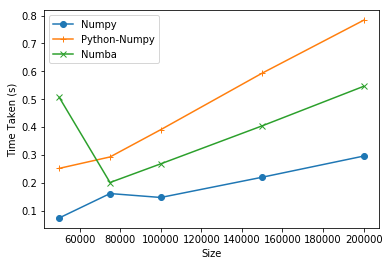

In [9]:
markers = itertools.cycle(('o', '+', 'x', 'd', 's')) 

for idx_key, key in enumerate(keys):
    x = experiments["size"]
    y = experiments[key]
    plt.plot(x, y, marker = next(markers), label=key)
plt.ylabel("Time Taken (s)")
plt.xlabel("Size")
plt.legend()
plt.show()

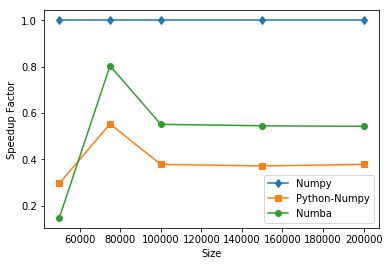

In [10]:
for idx_key, key in enumerate(keys):
    x = experiments["size"]
    y = np.asarray(experiments["Numpy"] / np.asarray(experiments[key]))
    plt.plot(x, y, marker = next(markers), label=key)
plt.ylabel("Speedup Factor")
plt.xlabel("Size")
plt.legend()
plt.show()